In [1]:
import os
import pandas as pd 
import numpy as np
import warnings
import json 

import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

from neuron_morphology.swc_io import morphology_from_swc
from morph_utils.visuals import basic_morph_plot
from morph_utils.measurements import leftextent, rightextent #cellwidth, downextent, upextent
from morph_utils.templates import load_layer_template 

import sys 
sys.path.append(r'..\utils') 
from utils import add_swc_paths, get_seaad_colors, get_tx_order


In [2]:
viewer_type = 'dendrite' #dendrite, axon, both 
species = "human"

In [3]:
#HANN mapping
class_col = 'class_label_Hierarchical'
subclass_col = 'subclass_label_Hierarchical'
cluster_col = 'cluster_label_Hierarchical'

out_dir = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\analysis\20251010_seaad\supplemental_viewers'
os.makedirs(out_dir, exist_ok=True)

cells_path = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\Features\{}\metadata.csv'.format(viewer_type)
viewer_outfile = os.path.join(out_dir, 'human_excitatory_{}_viewer.pdf'.format(viewer_type))

# node types to plot i.e. [soma, axon, basal, apical] 
if viewer_type == 'both': compartment_list=[1,2,3,4]
elif viewer_type == 'axon': compartment_list=[1,2]
elif viewer_type == 'dendrite': compartment_list=[1,3,4] 

ttype_var_name = cluster_col
subclass_var_name = subclass_col
sort_by = [ttype_var_name, 'soma_distance_from_pia'] 
num_rows = 7

with open(r"\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\formatting_dicts\L23_ttype_rename.json", "r") as f:
    L23_ttype_rename_dict = json.load(f)

#optional 
layer_aligned_dir = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\SWC_LayerAligned' #path to folder with layer aligned swcs for these cells 
soma_depths_path = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\Features\{}\AlignedSomaDepths.csv'.format(viewer_type) #if need to add soma depths to the file 
title = ['lobe']  #cluster_col, 
title_font_size = [2] 

Organize

In [4]:
# Load data
cells = pd.read_csv(cells_path, index_col='specimen_id')
if 'soma_depths_path' in locals(): #add soma depths 
    soma_depths = pd.read_csv(soma_depths_path)
    cells = cells.merge(soma_depths, how='inner', on='specimen_id')
cells = cells.rename(columns={'soma_distance_from_pia_x':'soma_distance_from_pia'})

cells[subclass_col] = cells[subclass_col].replace('L5 ET_ME', 'L5 ET').replace('L5 ET(ME)', 'L5 ET')
cells[cluster_col] = cells[cluster_col].replace('L5 ET_ME', 'L5 ET(ME)')
cells[cluster_col] = cells[cluster_col].apply(lambda x: L23_ttype_rename_dict.get(x, x))

# Get layer and color data
layer_info, layer_labels, layer_colors = load_layer_template(species)
color_dict = get_seaad_colors()

# Set some vars
cluster_var = sort_by[0]

set_side = [False] #xy

# Get layer aligned files
cells = add_swc_paths(cells, layer_aligned_dir, column_name='SWC_layer_aligned')

# Get subclass/ttype order for sorting
ttype_order, subclass_order = get_tx_order() #cells, ttype_var_name)
cells[ttype_var_name] = pd.Categorical(cells[ttype_var_name], categories=ttype_order, ordered=True)
cells[subclass_var_name] = pd.Categorical(cells[subclass_var_name], categories=subclass_order, ordered=True)

# Sort cells 
if all(item in list(cells.columns) for item in sort_by): #check if all items in sort_by are column names in cells 
    sorted_cells = cells.sort_values(by=sort_by)
else:
    print('Warning: cannot sort cells. Some value(s) in \'sort_by\' are not column names in input cell csv. Plotting unsorted cells.')
    sorted_cells = cells


Plot

Sps list is 319 long


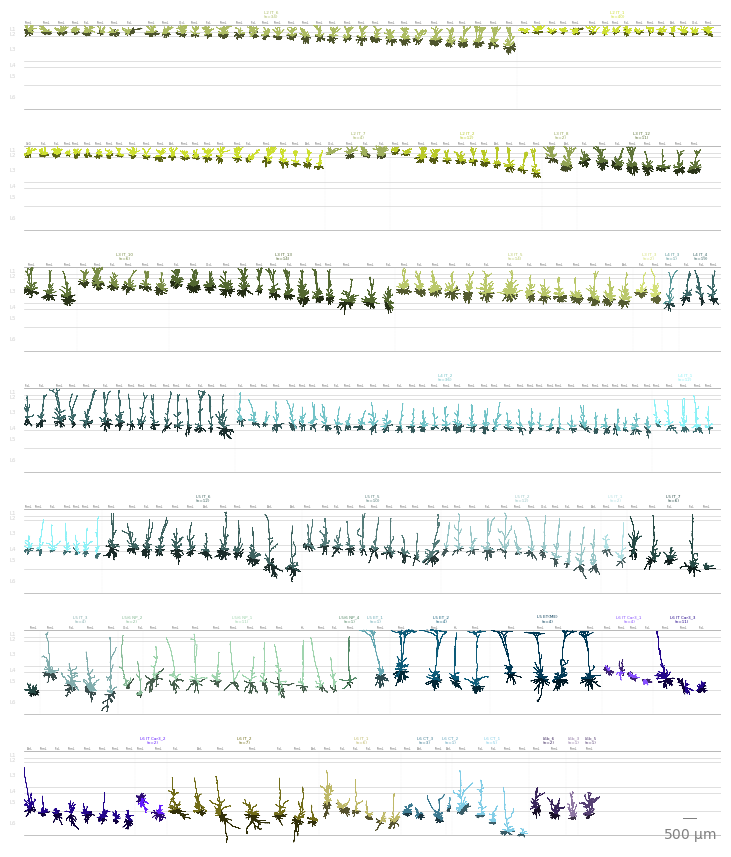

<Figure size 640x480 with 0 Axes>

In [ ]:
#make pdf viewer

#formatting vars for tinkering 
group_title_start_height = 300 #900 #starting height for group (e.g., region) title 
group_title_font_size = 4 #font size for group (e.g., region) title 

cell_title_start_height = 250 #700 #starting height for cell title 
cell_title_vertical_space = 200 #150 #how much white space between rows of the cell title
cell_title_view_font_size = 4 #font size for cell 'xy', 'yz' view label

#####

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

    sps_list = list(sorted_cells.specimen_id.values)
    sps_list.reverse() #because we pop() off spc, which takes off the last value in the list. Reversing here keeps the plotting order consistent with the csv order.

    clust_id_set = set()
    failed_to_load = []

    print("Sps list is {} long".format(len(sps_list)))
    buffer=100
    with PdfPages(viewer_outfile) as pdf:
        while sps_list != []:
            fig, axes = plt.subplots(nrows=num_rows,ncols=1,figsize=(9,11),sharex=True,sharey=True) 

            title_dict = {} # accumulate info for plotting group (cluster) title centered over the cells 
            
            for ax in axes: 

                ax.axis('off')
                ax.set_xlim(0,25600) 
                lim = 25500
                xloc = 0
                xoffset = 0
                ax.set_anchor('W')
                ax.axhline(0, c="lightgrey",linewidth=0.50)

                # Plot layers with labels 
                for l in layer_info:
                    ax.axhline(-layer_info[l], c=layer_colors[l],linewidth=0.50)
                for l in layer_labels:
                    ax.text(-500,-layer_labels[l], "{}".format(l),verticalalignment='center', horizontalalignment='left',fontsize=4, color='lightgrey') 

                group_start_loc = xloc
                cluster_start_ax = ax
                cluster_start_x = xoffset
                current_cluster_id = None

                while xloc < lim:  # plot as many neurons as fit on this row
                    if not sps_list:
                        break

                    sp = sps_list.pop()

                    # get specimen metadata
                    ttype = sorted_cells.loc[sorted_cells.specimen_id == sp, ttype_var_name].iloc[0]
                    clust_id = sorted_cells.loc[sorted_cells.specimen_id == sp, cluster_var].iloc[0]
                    clust_len = len(sorted_cells.loc[sorted_cells[cluster_var] == clust_id])

                    # cell title
                    sp_title = []
                    if 'title' in locals():
                        for t in title:
                            sp_title.append(str(sorted_cells.loc[sorted_cells.specimen_id == sp, t].iloc[0]))

                    # get plotting colors
                    try:
                        hex_color = color_dict[ttype][1:]
                        contrast_level = 0.45
                        lighter_color_rgb = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
                        darker_color_rgb = tuple([int((contrast_level*x)) for x in lighter_color_rgb])
                        grey_hex = '#8f8f8f'
                        dark_hex = '#%02x%02x%02x' % darker_color_rgb
                        hex_color = '#'+hex_color
                        cell_type_colors_dict = {3: dark_hex, 4: hex_color, 2: grey_hex}
                        if compartment_list == [1,2]:
                            cell_type_colors_dict = {3: grey_hex, 4: grey_hex, 2: hex_color}
                    except:
                        cell_type_colors_dict = {1: 'black', 2: "firebrick", 4: "orange", 3: "steelblue"}
                    morph_colors = {k: v for k, v in cell_type_colors_dict.items() if k in compartment_list}

                    # get the morphology
                    swc_pth = sorted_cells.loc[sorted_cells.specimen_id == sp, 'SWC_layer_aligned'].iloc[0]
                    nrn = morphology_from_swc(swc_pth)

                    cell_left = leftextent(nrn, compartment_list)
                    cell_right = rightextent(nrn, compartment_list)

                    # check width limit for this row
                    if xoffset + cell_left + cell_right > lim:
                        # # Cluster split across rows → finalize the previous cluster title on this axis
                        if current_cluster_id is not None:
                            midpoint = cluster_start_x + (xoffset - cluster_start_x) / 2
                            cluster_string = f"{current_cluster_id}\n(n={prev_clust_len})"
                            if not cluster_string in title_dict.keys():
                                title_dict[cluster_string] = {
                                    'ax': cluster_start_ax,
                                    'xloc': midpoint,
                                    'color': current_cluster_color
                                }
                        # push cell back and move to next axis
                        sps_list.append(sp)
                        break

                    # Detect cluster boundary
                    if clust_id != current_cluster_id:
                        # Finish previous cluster if there was one
                        if current_cluster_id is not None:
                            midpoint = cluster_start_x + (xoffset - cluster_start_x) / 2
                            cluster_string = f"{current_cluster_id}\n(n={prev_clust_len})"
                            if not cluster_string in title_dict.keys():
                                title_dict[cluster_string] = {
                                    'ax': cluster_start_ax,
                                    'xloc': midpoint,
                                    'color': current_cluster_color
                                }

                        # Start a new cluster
                        current_cluster_id = clust_id
                        cluster_start_x = xoffset
                        cluster_start_ax = ax
                        current_cluster_color = hex_color
                        prev_clust_len = clust_len

                        vert_x = xoffset - (buffer / 2)
                        ax.plot([vert_x, vert_x], [0, -layer_info['wm']], c='lightgrey', lw=0.1, linestyle='--')

                    xoffset += cell_left

                    # plot cell title
                    y = cell_title_start_height
                    for i, l in enumerate(sp_title):
                        y -= cell_title_vertical_space
                        ax.text(xoffset, y, l, ha='center', fontsize=title_font_size[i], color=color_dict.get(l, 'dimgrey'))

                    # draw the neuron
                    y -= cell_title_vertical_space
                    for s in set_side:
                        basic_morph_plot(
                            nrn, morph_colors=morph_colors, ax=ax, xoffset=xoffset,
                            side=s, scatter_roots=False, scatter_soma=False, plot_soma=False, line_w=0.2
                        )
                        xoffset += cell_right + buffer

                    xloc = xoffset

                # After finishing all cells on this axis, close any open cluster
                if current_cluster_id is not None:
                    midpoint = cluster_start_x + (xoffset - cluster_start_x) / 2
                    cluster_string = f"{current_cluster_id}\n(n={prev_clust_len})"
                    if not cluster_string in title_dict.keys():
                        title_dict[cluster_string] = {
                            'ax': cluster_start_ax,
                            'xloc': midpoint,
                            'color': current_cluster_color
                        }

            
            #add a scale bar 
            scalebar = ScaleBar(1, "um", location='lower right', frameon=False, fixed_value=500, color='grey')
            ax.add_artist(scalebar)

            for title_str, title_specs in title_dict.items():
                    ax = title_specs['ax']
                    ax.text(title_specs['xloc'], group_title_start_height, title_str, horizontalalignment='center', fontsize=3, color=title_specs['color'])  
            
            for ax in axes:
                ax.set_aspect("equal")
            fig.subplots_adjust(wspace=0, hspace=0.0)
            pdf.savefig(dpi=600)
    plt.show()
    plt.clf()
    print()
